In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import trapezoid
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
# Your Roll Number
ROLL_NUMBER = 102303335

print(f"Roll Number: {ROLL_NUMBER}")


Roll Number: 102303335


In [3]:
df = pd.read_csv('data.csv', encoding='latin-1')
x_data = df['no2'].dropna().values

print(f"Dataset loaded: {len(x_data)} samples")
print(f"Mean: {np.mean(x_data):.2f}, Std: {np.std(x_data):.2f}")
print(f"Min: {np.min(x_data):.2f}, Max: {np.max(x_data):.2f}")

Dataset loaded: 419509 samples
Mean: 25.81, Std: 18.50
Min: 0.00, Max: 876.00


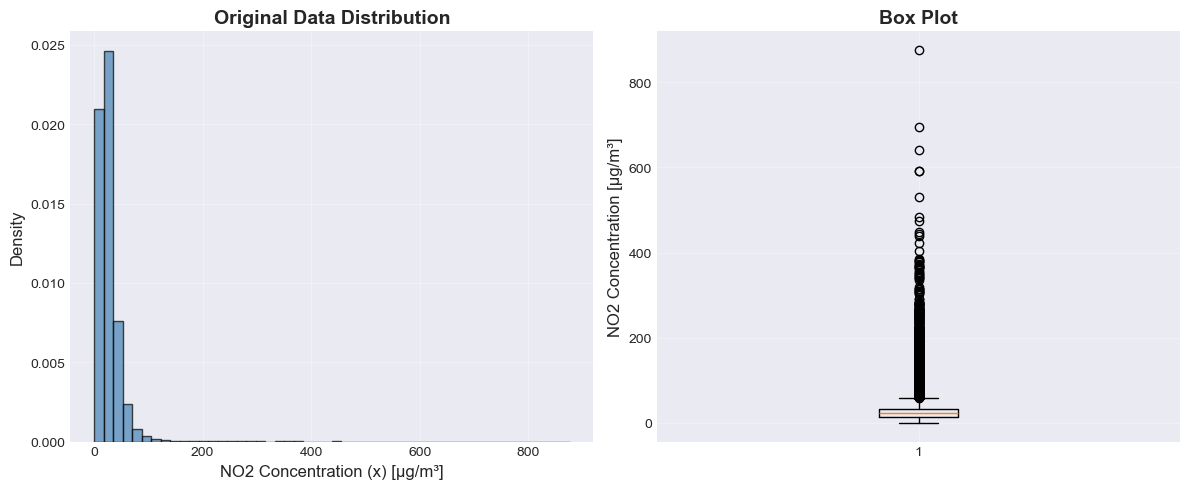

In [4]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x_data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
plt.xlabel('NO2 Concentration (x) [µg/m³]', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Original Data Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(x_data, vert=True)
plt.ylabel('NO2 Concentration [µg/m³]', fontsize=12)
plt.title('Box Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
r = ROLL_NUMBER
a_r = 0.05 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(f"Roll Number (r): {r}")
print(f"a_r = 0.05 × ({r} mod 7) = 0.05 × {r % 7} = {a_r:.6f}")
print(f"b_r = 0.3 × (({r} mod 5) + 1) = 0.3 × ({r % 5} + 1) = {b_r:.6f}")

Roll Number (r): 102303335
a_r = 0.05 × (102303335 mod 7) = 0.05 × 1 = 0.050000
b_r = 0.3 × ((102303335 mod 5) + 1) = 0.3 × (0 + 1) = 0.300000


In [6]:
def transform_x_to_z(x, a_r, b_r):
    return x + a_r * np.sin(b_r * x)

z_data = transform_x_to_z(x_data, a_r, b_r)

print(f"Transformation: z = x + {a_r:.6f} × sin({b_r:.6f} × x)")
print(f"Mean: {np.mean(z_data):.2f}, Std: {np.std(z_data):.2f}")
print(f"Min: {np.min(z_data):.2f}, Max: {np.max(z_data):.2f}")

Transformation: z = x + 0.050000 × sin(0.300000 × x)
Mean: 25.81, Std: 18.50
Min: 0.00, Max: 875.96


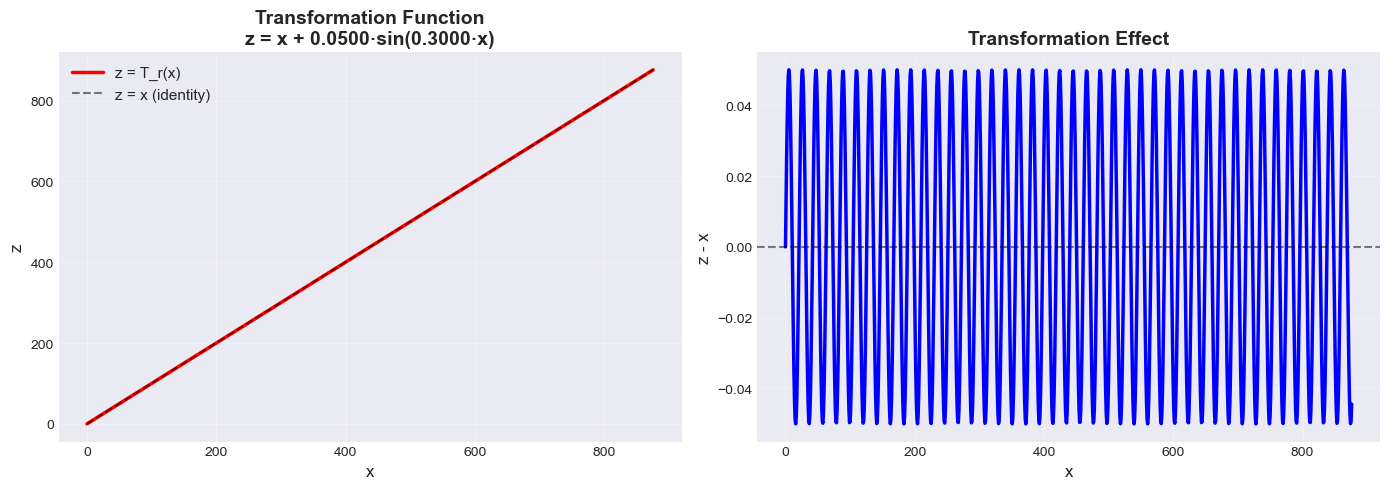

In [7]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
x_range = np.linspace(x_data.min(), x_data.max(), 1000)
z_range = transform_x_to_z(x_range, a_r, b_r)
plt.plot(x_range, z_range, 'r-', linewidth=2.5, label='z = T_r(x)')
plt.plot(x_range, x_range, 'k--', alpha=0.5, linewidth=1.5, label='z = x (identity)')
plt.xlabel('x', fontsize=12)
plt.ylabel('z', fontsize=12)
plt.title(f'Transformation Function\nz = x + {a_r:.4f}·sin({b_r:.4f}·x)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
difference = z_range - x_range
plt.plot(x_range, difference, 'b-', linewidth=2.5)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.xlabel('x', fontsize=12)
plt.ylabel('z - x', fontsize=12)
plt.title('Transformation Effect', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

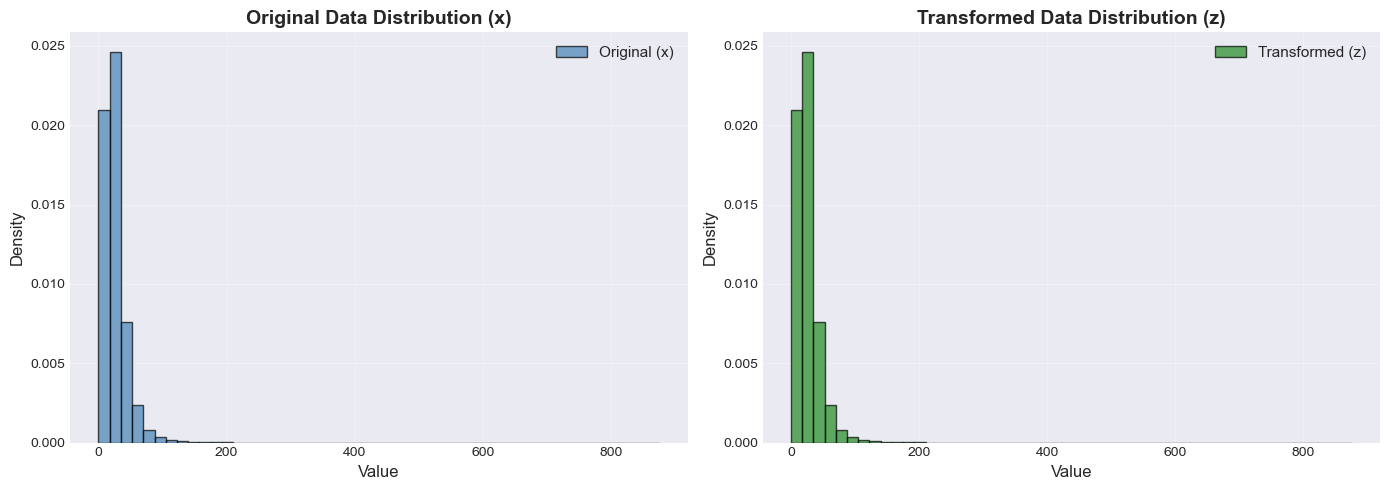

In [8]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.hist(x_data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', label='Original (x)')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Original Data Distribution (x)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(z_data, bins=50, density=True, alpha=0.7, color='forestgreen', edgecolor='black', label='Transformed (z)')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Transformed Data Distribution (z)', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
def pdf_model(z, lambda_param, mu, c):
    return c * np.exp(-lambda_param * (z - mu)**2)

print("PDF Model: p̂(z) = c × e^(-λ(z-μ)²)")
print("Parameters to estimate: λ, μ, c")

PDF Model: p̂(z) = c × e^(-λ(z-μ)²)
Parameters to estimate: λ, μ, c


In [10]:
hist, bin_edges = np.histogram(z_data, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

print(f"Histogram prepared with {len(hist)} bins")
print(f"Data range: [{bin_edges[0]:.2f}, {bin_edges[-1]:.2f}]")

Histogram prepared with 50 bins
Data range: [0.00, 875.96]


In [11]:
mu_init = np.mean(z_data)
std_z = np.std(z_data)
lambda_init = 1 / (2 * std_z**2)
c_init = 1 / (np.sqrt(2 * np.pi) * std_z)

print(f"Initial estimates:")
print(f"  μ_init  = {mu_init:.6f}")
print(f"  λ_init  = {lambda_init:.6f}")
print(f"  c_init  = {c_init:.6f}")

Initial estimates:
  μ_init  = 25.807910
  λ_init  = 0.001460
  c_init  = 0.021561


In [12]:
popt, pcov = curve_fit(pdf_model, bin_centers, hist, p0=[lambda_init, mu_init, c_init], maxfev=10000)

lambda_fitted, mu_fitted, c_fitted = popt
perr = np.sqrt(np.diag(pcov))

print("FITTED PARAMETERS:")
print(f"  λ (lambda) = {lambda_fitted:.6f}")
print(f"  μ (mu)     = {mu_fitted:.6f}")
print(f"  c          = {c_fitted:.6f}")
print(f"\nStandard Errors:")
print(f"  σ_λ = {perr[0]:.6f}")
print(f"  σ_μ = {perr[1]:.6f}")
print(f"  σ_c = {perr[2]:.6f}")

FITTED PARAMETERS:
  λ (lambda) = 0.002058
  μ (mu)     = 19.627049
  c          = 0.026806

Standard Errors:
  σ_λ = 0.000068
  σ_μ = 0.208611
  σ_c = 0.000293


In [13]:
z_range_fine = np.linspace(z_data.min(), z_data.max(), 1000)
pdf_values = pdf_model(z_range_fine, lambda_fitted, mu_fitted, c_fitted)
integral = trapezoid(pdf_values, z_range_fine)

print(f"∫p̂(z)dz = {integral:.6f}")
print(f"Expected: ≈ 1.0")
print(f"Error: {abs(1.0 - integral):.6f}")

∫p̂(z)dz = 0.938340
Expected: ≈ 1.0
Error: 0.061660


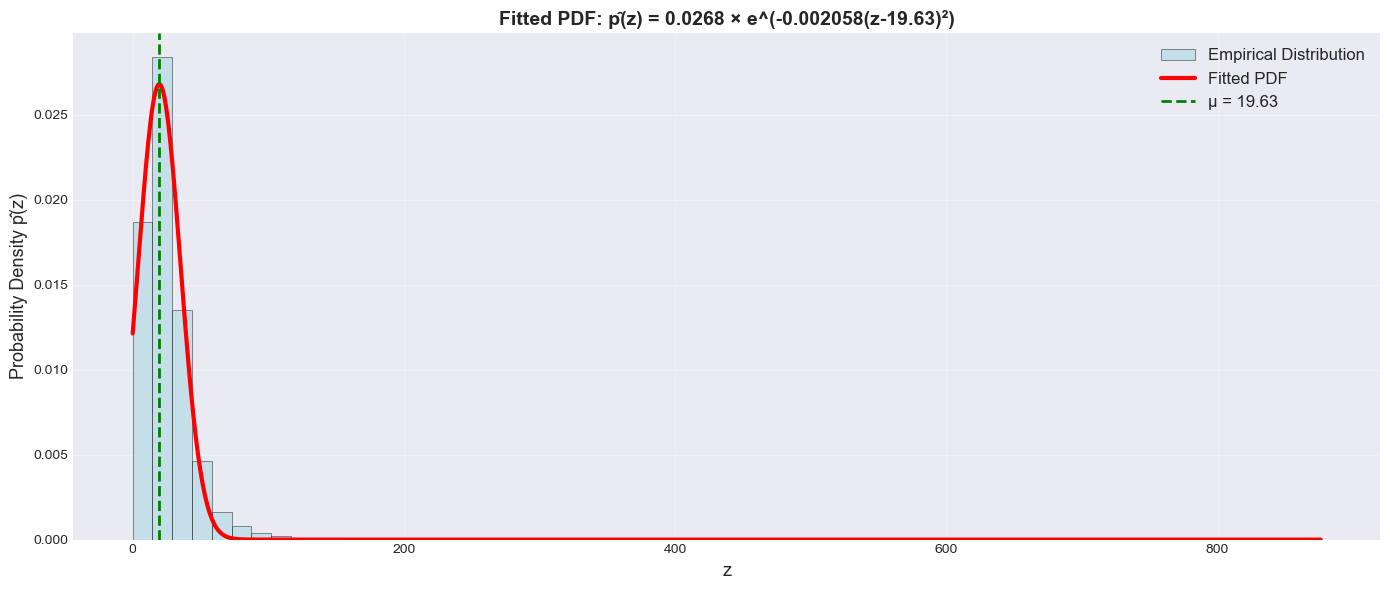

In [15]:
plt.figure(figsize=(14, 6))

plt.hist(z_data, bins=60, density=True, alpha=0.6, color='lightblue', edgecolor='black', linewidth=0.5, label='Empirical Distribution')
plt.plot(z_range_fine, pdf_values, 'r-', linewidth=3, label='Fitted PDF')
plt.axvline(mu_fitted, color='green', linestyle='--', linewidth=2, label=f'μ = {mu_fitted:.2f}')

plt.xlabel('z', fontsize=13)
plt.ylabel('Probability Density p̂(z)', fontsize=13)
plt.title(f'Fitted PDF: p̂(z) = {c_fitted:.4f} × e^(-{lambda_fitted:.6f}(z-{mu_fitted:.2f})²)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

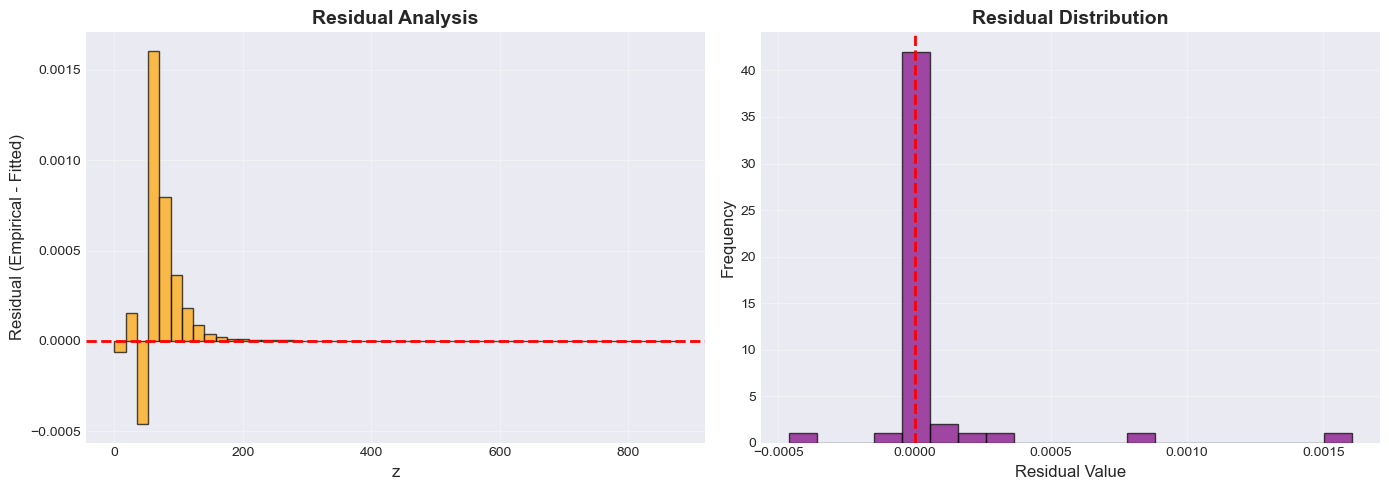

Mean residual: 0.000055
Std residual: 0.000263


In [16]:
fitted_at_centers = pdf_model(bin_centers, lambda_fitted, mu_fitted, c_fitted)
residuals = hist - fitted_at_centers

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(bin_centers, residuals, width=(bin_edges[1]-bin_edges[0]), alpha=0.7, color='orange', edgecolor='black')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('z', fontsize=12)
plt.ylabel('Residual (Empirical - Fitted)', fontsize=12)
plt.title('Residual Analysis', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, alpha=0.7, color='purple', edgecolor='black')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Residual Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Residual Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mean residual: {np.mean(residuals):.6f}")
print(f"Std residual: {np.std(residuals):.6f}")

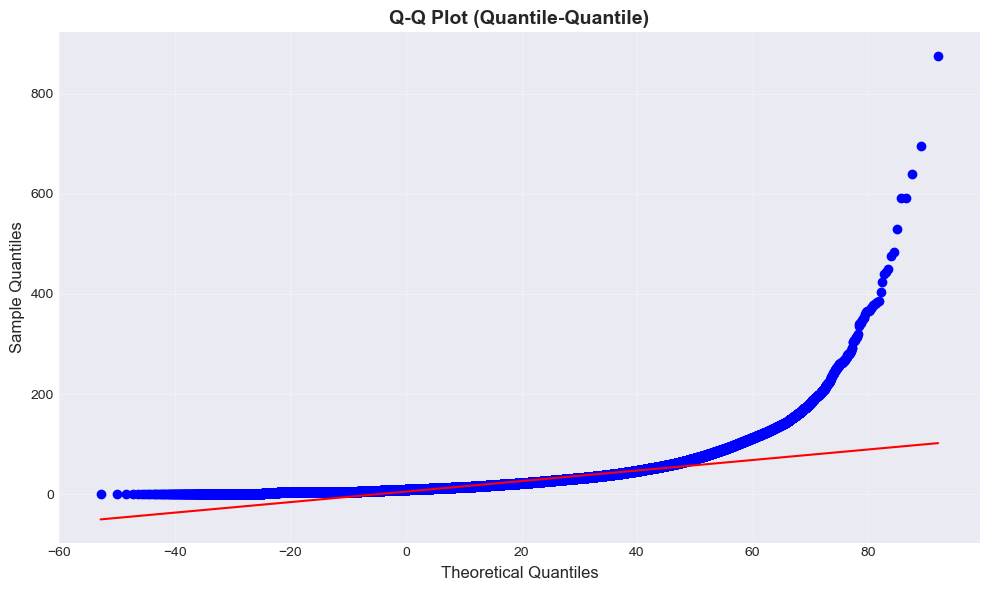

In [21]:
plt.figure(figsize=(10, 6))

stats.probplot(z_data, dist=stats.norm, sparams=(mu_fitted, 1/np.sqrt(2*lambda_fitted)), plot=plt)
plt.title('Q-Q Plot (Quantile-Quantile)', fontsize=14, fontweight='bold')
plt.xlabel('Theoretical Quantiles', fontsize=12)
plt.ylabel('Sample Quantiles', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

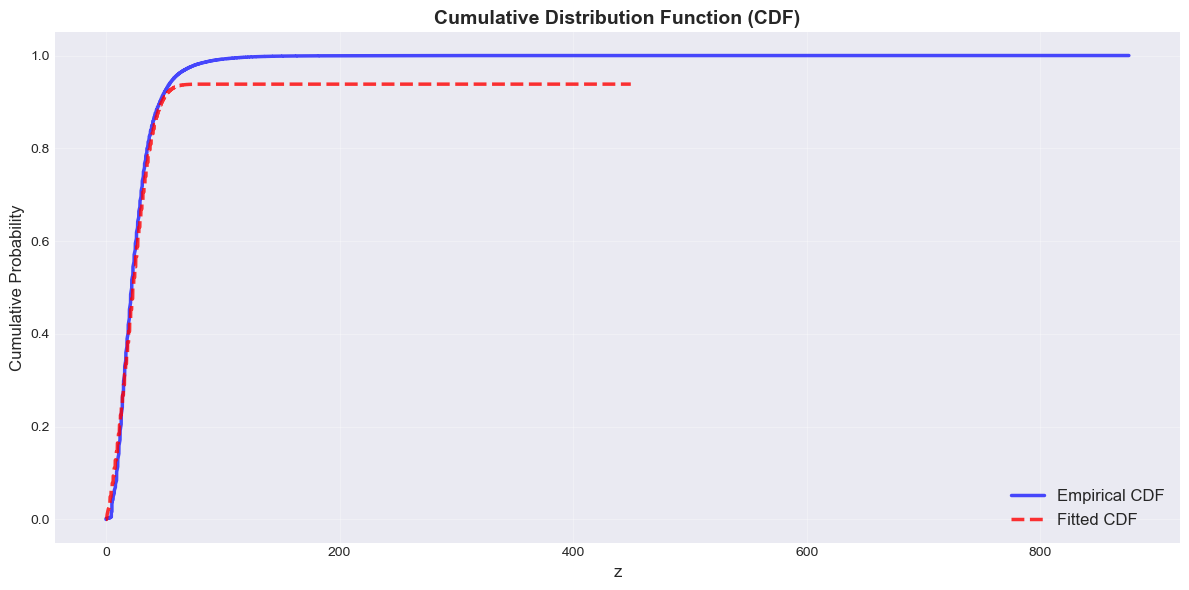

In [22]:
plt.figure(figsize=(12, 6))

z_sorted = np.sort(z_data)
cdf_empirical = np.arange(1, len(z_sorted)+1) / len(z_sorted)

plt.plot(z_sorted, cdf_empirical, 'b-', linewidth=2.5, label='Empirical CDF', alpha=0.7)

cdf_theoretical = []
for z_val in z_sorted[::50]:
    mask = z_range_fine <= z_val
    if np.sum(mask) > 1:
        integral_val = trapezoid(pdf_model(z_range_fine[mask], lambda_fitted, mu_fitted, c_fitted), z_range_fine[mask])
        cdf_theoretical.append(integral_val)
    else:
        cdf_theoretical.append(0)

plt.plot(z_sorted[::50], cdf_theoretical, 'r--', linewidth=2.5, label='Fitted CDF', alpha=0.8)

plt.xlabel('z', fontsize=12)
plt.ylabel('Cumulative Probability', fontsize=12)
plt.title('Cumulative Distribution Function (CDF)', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
from scipy.stats import ks_2samp

theoretical_samples = np.random.normal(mu_fitted, 1/np.sqrt(2*lambda_fitted), 10000)
ks_stat, ks_pval = ks_2samp(z_data, theoretical_samples)

mse = np.mean(residuals**2)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((hist - np.mean(hist))**2)
r_squared = 1 - (ss_res / ss_tot)

print("GOODNESS-OF-FIT METRICS:")
print(f"  KS Statistic: {ks_stat:.6f}")
print(f"  KS p-value: {ks_pval:.6f}")
print(f"  MSE: {mse:.8f}")
print(f"  R²: {r_squared:.6f}")
print(f"  ∫p̂(z)dz: {integral:.6f}")

GOODNESS-OF-FIT METRICS:
  KS Statistic: 0.159552
  KS p-value: 0.000000
  MSE: 0.00000007
  R²: 0.996534
  ∫p̂(z)dz: 0.938340


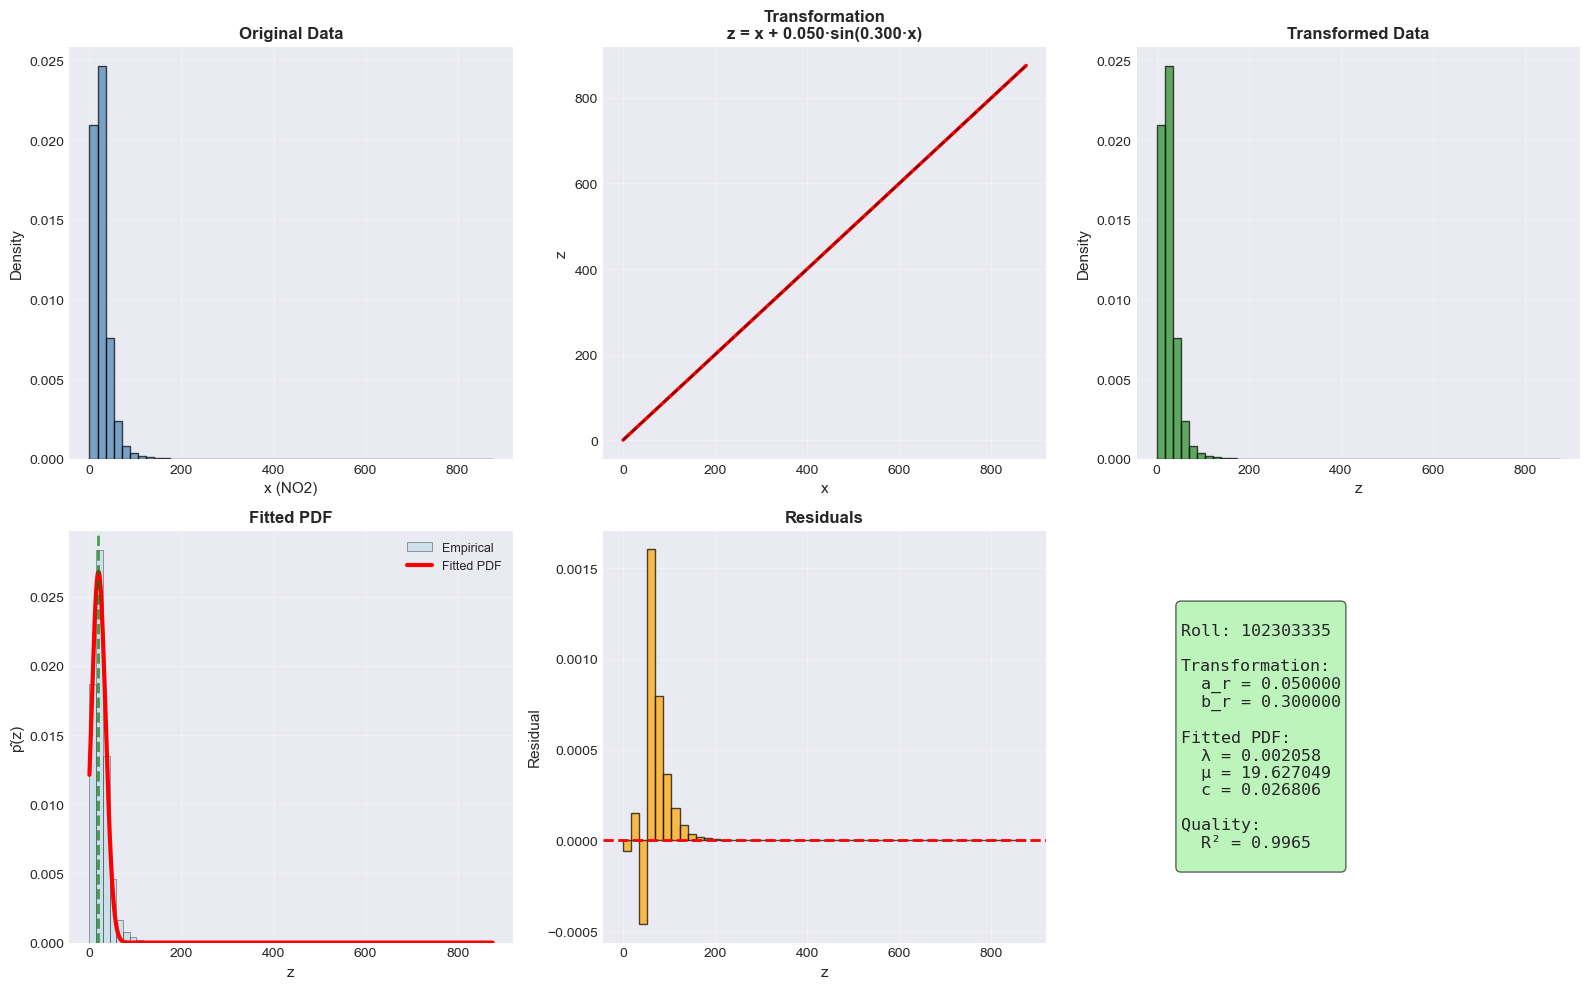


SUBMIT THESE VALUES:
λ = 0.002058
μ = 19.627049
c = 0.026806


In [25]:
fig = plt.figure(figsize=(16, 10))

ax1 = plt.subplot(2, 3, 1)
ax1.hist(x_data, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black')
ax1.set_xlabel('x (NO2)', fontsize=11)
ax1.set_ylabel('Density', fontsize=11)
ax1.set_title('Original Data', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2 = plt.subplot(2, 3, 2)
x_plot = np.linspace(x_data.min(), x_data.max(), 500)
z_plot = transform_x_to_z(x_plot, a_r, b_r)
ax2.plot(x_plot, z_plot, 'r-', linewidth=2.5)
ax2.plot(x_plot, x_plot, 'k--', alpha=0.5)
ax2.set_xlabel('x', fontsize=11)
ax2.set_ylabel('z', fontsize=11)
ax2.set_title(f'Transformation\nz = x + {a_r:.3f}·sin({b_r:.3f}·x)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

ax3 = plt.subplot(2, 3, 3)
ax3.hist(z_data, bins=50, density=True, alpha=0.7, color='forestgreen', edgecolor='black')
ax3.set_xlabel('z', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('Transformed Data', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

ax4 = plt.subplot(2, 3, 4)
ax4.hist(z_data, bins=60, density=True, alpha=0.5, color='lightblue', edgecolor='black', linewidth=0.5, label='Empirical')
ax4.plot(z_range_fine, pdf_values, 'r-', linewidth=3, label='Fitted PDF')
ax4.axvline(mu_fitted, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax4.set_xlabel('z', fontsize=11)
ax4.set_ylabel('p̂(z)', fontsize=11)
ax4.set_title('Fitted PDF', fontsize=12, fontweight='bold')
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)

ax5 = plt.subplot(2, 3, 5)
ax5.bar(bin_centers, residuals, width=(bin_edges[1]-bin_edges[0]), alpha=0.7, color='orange', edgecolor='black')
ax5.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax5.set_xlabel('z', fontsize=11)
ax5.set_ylabel('Residual', fontsize=11)
ax5.set_title('Residuals', fontsize=12, fontweight='bold')
ax5.grid(True, alpha=0.3)

ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')
summary_text = f"""
Roll: {ROLL_NUMBER}

Transformation:
  a_r = {a_r:.6f}
  b_r = {b_r:.6f}

Fitted PDF:
  λ = {lambda_fitted:.6f}
  μ = {mu_fitted:.6f}
  c = {c_fitted:.6f}

Quality:
  R² = {r_squared:.4f}
"""
ax6.text(0.1, 0.5, summary_text, fontsize=12, family='monospace', verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.6))

plt.tight_layout()
plt.show()

print(f"\nSUBMIT THESE VALUES:")
print(f"λ = {lambda_fitted:.6f}")
print(f"μ = {mu_fitted:.6f}")
print(f"c = {c_fitted:.6f}")